In [34]:
import os
import requests
from datetime import datetime as dt

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [35]:
URL = 'https://www.tepco.co.jp/forecast/html/images/juyo-result-j.csv'
FILE_DIR = '/home/wataru/code/crowdworks/FOR_SKYIT/assignment/pred_app/csv'
FILE_PATH = os.path.join(FILE_DIR, os.path.basename(URL))

### Data Over View

In [36]:
dataframe_src = pd.read_csv(FILE_PATH, header=1, encoding='shift-jis')

# データ最新日
dt_last = dt.strptime(list(dataframe_src.tail(1).DATE)[0], '%Y/%m/%d').date()

# 本日
dt_now = dt.today().date()

dataframe_src

,DATE,TIME,曜日,実績(万kW),ピーク時供給力,使用率,使用率ピーク時時間帯,使用率ピーク時需要電力,使用率ピーク時供給力,使用率ピーク時使用率
0,2022/1/1,20:00,6,3589,4183,85,22:00,3372,3893,86
1,2022/1/2,20:00,0,3594,4235,84,8:00,3459,3955,87
2,2022/1/3,19:00,1,3609,4472,80,0:00,2968,3429,86
3,2022/1/4,18:00,2,4086,4786,85,15:00,3464,3911,88
4,2022/1/5,18:00,3,4598,5179,88,19:00,4539,5058,89
5,2022/1/6,16:00,4,5374,5550,96,15:00,5273,5432,97
6,2022/1/7,9:00,5,5173,5328,97,9:00,5173,5328,97
7,2022/1/8,18:00,6,4209,4850,86,0:00,3593,3975,90
8,2022/1/9,18:00,0,3863,4943,78,0:00,3305,3980,83
9,2022/1/10,18:00,1,4163,5005,83,11:00,3809,4255,89


In [45]:
# 対象データの読み込み（デPATHータセット中のYのみロード）
dataframe = pd.read_csv(FILE_PATH, usecols=[7], header=1, encoding='shift-jis')
dataset = dataframe.values.astype('float32')
# dataset

### Scaling

In [38]:
# [0,1]に正規化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

### DataSet

In [39]:
# 訓練データとテストデータを分割（時系列の予測が目的のため、ある時点から先をテストデータとする）
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [40]:
# X=[data[t-look_back],...,data[t-1]], Y=data[t]となるデータセットに変換
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# [samples, time steps, features]へ変形
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

### Model

In [41]:
# LSTMにDenseを接続し、数値を予測（MSEで評価）
model = Sequential()

model.add(LSTM(4, input_shape=(look_back, 1))) # input_shape=(系列長T, x_tの次元), output_shape=(units,)
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

### Train

In [42]:
MODEL_DIR = os.path.join(os.getcwd(), 'pred_app/model')

batch_size = 2
epochs = 100

str_today = dt.today().strftime('%Y%m%d')
chkpt = os.path.join(MODEL_DIR, 'epower'+str_today+'_{epoch:02d}_{val_loss:.4f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
model.fit(x=trainX, y=trainY, validation_data=(testX, testY), batch_size=batch_size, epochs=epochs, verbose=2, callbacks=[cp_cb, es_cb])

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.02589, saving model to /home/wataru/code/crowdworks/FOR_SKYIT/pred_app/model/epower20220721_01_0.0259.hdf5
65/65 - 1s - loss: 0.0645 - val_loss: 0.0259 - 1s/epoch - 17ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.02589 to 0.02285, saving model to /home/wataru/code/crowdworks/FOR_SKYIT/pred_app/model/epower20220721_02_0.0228.hdf5
65/65 - 0s - loss: 0.0345 - val_loss: 0.0228 - 124ms/epoch - 2ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.02285 to 0.02274, saving model to /home/wataru/code/crowdworks/FOR_SKYIT/pred_app/model/epower20220721_03_0.0227.hdf5
65/65 - 0s - loss: 0.0331 - val_loss: 0.0227 - 123ms/epoch - 2ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.02274 to 0.02269, saving model to /home/wataru/code/crowdworks/FOR_SKYIT/pred_app/model/epower20220721_04_0.0227.hdf5
65/65 - 0s - loss: 0.0331 - val_loss: 0.0227 - 126ms/epoch - 2ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.02269
65/65 

### Accuracy

In [43]:
# テストデータに対する予測（評価のため訓練データも）
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 正規化を元に戻す
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# 平均二乗誤差のルートで評価
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

2/2 [==============================] - 0s 2ms/step
Train RMSE: 581.87
Test RMSE: 493.54


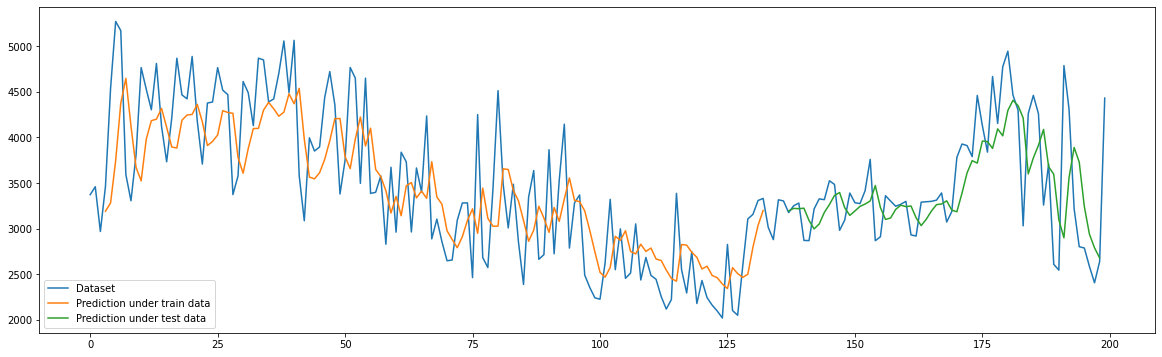

In [44]:
# 訓練データ部分の予測データ
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# テストデータ部分の予測データ
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(20)
plt.plot(scaler.inverse_transform(dataset), label='Dataset')
plt.plot(trainPredictPlot, label='Prediction under train data')
plt.plot(testPredictPlot, label='Prediction under test data')
plt.legend()
plt.show()